
Start Notebook 3 — Clustering

Loaded: ../2_data_preparation/final_cleaned_dataset.csv
Shape: (121, 115)
Run at: 2025-12-05T10:26:21.847627 UTC

Group sizes after filtering:
Households: 0
Schools   : 121
Health    : 0

Household clustering

Chosen household features: ['household_size', 'role_in_household', 'litres_per_person_per_day_num', 'distance_to_water_source_numeric', 'weekly_water_cost_ssp', 'household_shortage_frequency_num', 'household_shortage_seriousness']
Skipping Household: only 0 rows (min 8).

School clustering

Chosen school features: ['school_student_population', 'school_staff_population', 'school_monthly_water_cost_ssp', 'school_hours_water_available_numeric', 'school_type', 'school_ownership']
School: transformed shape (121, 22) (numeric 2, cat 4)
📁 Saved chart to: ../5_communication/charts\school_elbow_silhouette.png


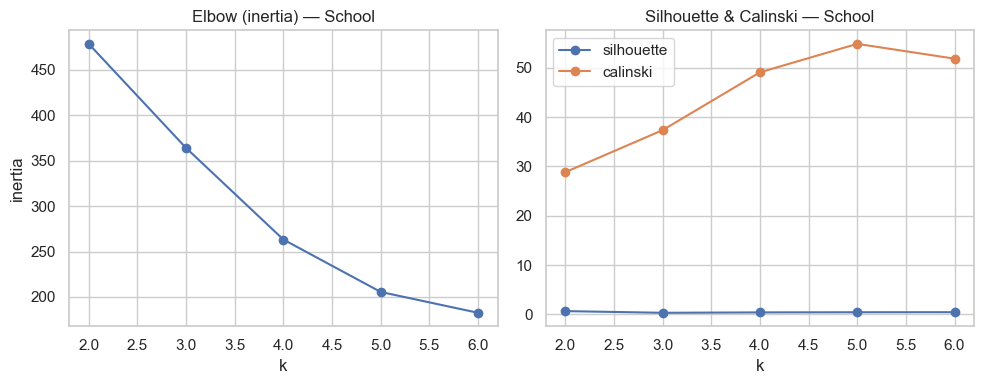

School: suggested k = 2
📁 Saved chart to: ../5_communication/charts\school_pca_clusters.png


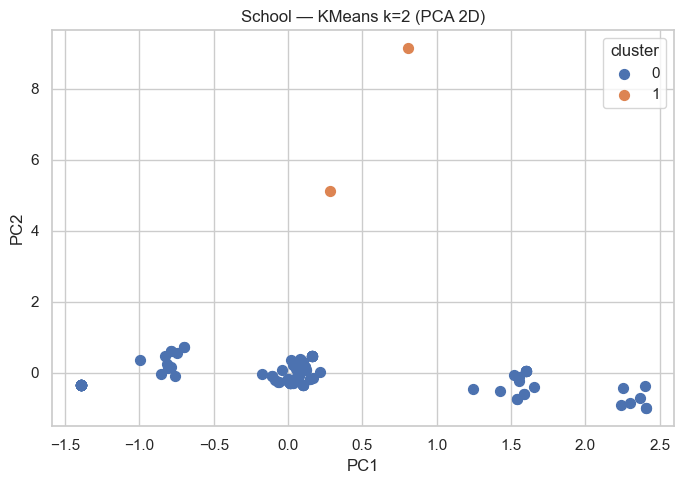

School diagnostics: {'n_clusters': 2, 'silhouette': 0.6661229348371903, 'calinski': 28.819600608203597}

Cluster means (numeric features):


,school_monthly_water_cost_ssp,school_hours_water_available_numeric
cluster_kmeans,,
0,9.321958e+06,5.333333
1,4.000006e+11,4.000000


📁 Saved chart to: ../5_communication/charts\school_boxplots_numeric.png


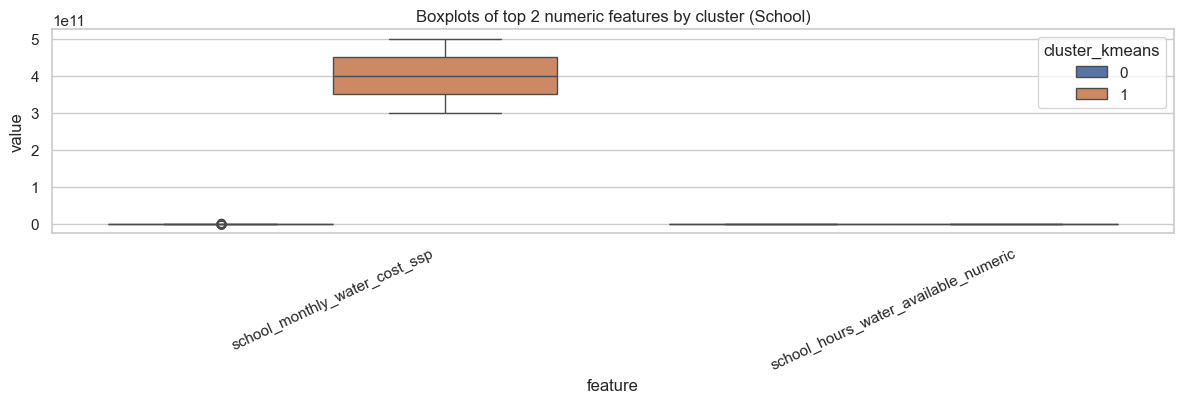

Saved clustered dataframe to: ./notebook3_outputs\school_clusters.csv

Health clustering

Chosen health features: ['health_daily_patients', 'health_staff_count', 'health_water_reliability_numeric', 'health_monthly_water_cost_ssp', 'health_shortage_frequency_numeric', 'health_service_disruptions_numeric']
Skipping Health: only 0 rows (min 8).

Clustering Summary

Household clusters saved to: skipped
School clusters saved to   : ./notebook3_outputs\school_clusters.csv
Health clusters saved to   : skipped

Notebook 3 (clustering) completed successfully.


In [6]:
# =========================
# Notebook 3 — FINAL (Correct & Reliable)
# Clustering: Household | School | Health
# =========================

# -------------------------
# IMPORTS
# -------------------------
import os
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


# Saves charts to: 5_communication/charts/

CHART_DIR = "../5_communication/charts"
os.makedirs(CHART_DIR, exist_ok=True)


def save_fig(name, fig=None, dpi=150):
    if fig is None:
        fig = plt.gcf()
    path = os.path.join(CHART_DIR, f"{name}.png")
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"📁 Saved chart to: {path}")


# -------------------------
# CONFIG
# -------------------------
RANDOM_STATE = 42
DATA_PATH = "../2_data_preparation/final_cleaned_dataset.csv"  # adjust if necessary
SAVE_DIR = "./notebook3_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)
MIN_ROWS = 8  # minimum rows to attempt clustering
K_RANGE = range(2, 7)  # evaluate k = 2..6


# -------------------------
# HELPER FUNCTIONS
# -------------------------
def section(title):
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title) + "\n")


def load_data(path=DATA_PATH):
    df = pd.read_csv(path)
    print("Loaded:", path)
    print("Shape:", df.shape)
    print("Run at:", datetime.utcnow().isoformat(), "UTC")
    return df


def filter_rows_for_group(df):
    """
    Return three DataFrames: household_df, school_df, health_df.
    Uses multiple heuristics based on available columns.
    """
    # Household indicators (common household columns)
    household_keys = [
        "role_in_household",
        "household_size",
        "litres_per_person_per_day_num",
        "litres_per_person_per_day",
        "primary_income",
        "weekly_water_cost_ssp",
        "distance_to_water_source_numeric",
        "household_shortage_frequency_num",
    ]
    # School indicators
    school_keys = [
        "school_affiliation",
        "school_role",
        "school_type",
        "school_ownership",
        "school_student_population",
        "school_staff_population",
        "school_monthly_water_cost_ssp",
        "school_hours_water_available_numeric",
    ]
    # Health indicators
    health_keys = [
        "health_affiliation",
        "health_facility_typehealth_facility_type",
        "health_facility_ownership",
        "health_daily_patients",
        "health_staff_count",
        "health_water_reliability_numeric",
        "health_monthly_water_cost_ssp",
    ]

    # Heuristic: row belongs to group if any of its indicator columns are not null / not NaN
    household_mask = pd.Series(False, index=df.index)
    for c in household_keys:
        if c in df.columns:
            household_mask |= df[c].notna()

    school_mask = pd.Series(False, index=df.index)
    for c in school_keys:
        if c in df.columns:
            school_mask |= df[c].notna()

    health_mask = pd.Series(False, index=df.index)
    for c in health_keys:
        if c in df.columns:
            health_mask |= df[c].notna()

    # Some rows might satisfy multiple masks; break ties by priority:
    # If school column present and non-null -> school; else health; else household.
    # We'll build final masks in that priority order.
    school_rows = df[school_mask].copy()
    # remove those from other masks
    remaining_mask = ~(school_mask)
    health_mask = health_mask & remaining_mask
    health_rows = df[health_mask].copy()
    remaining_mask = remaining_mask & ~health_mask
    household_mask = household_mask & remaining_mask
    household_rows = df[household_mask].copy()

    # If any group is empty, attempt alternative heuristics:
    # e.g., rows with 'household_' prefixed columns or 'school_' or 'health_' prefixes
    if household_rows.shape[0] < MIN_ROWS:
        pref_household = [c for c in df.columns if c.startswith("household_")]
        if pref_household:
            alt_mask = df[pref_household].notna().any(axis=1)
            household_rows = pd.concat(
                [household_rows, df[alt_mask & ~school_mask & ~health_mask]]
            )
            household_rows = household_rows.drop_duplicates().copy()

    if school_rows.shape[0] < MIN_ROWS:
        pref_school = [c for c in df.columns if c.startswith("school_")]
        if pref_school:
            alt_mask = df[pref_school].notna().any(axis=1)
            school_rows = pd.concat([school_rows, df[alt_mask & ~health_mask]])
            school_rows = school_rows.drop_duplicates().copy()

    if health_rows.shape[0] < MIN_ROWS:
        pref_health = [c for c in df.columns if c.startswith("health_")]
        if pref_health:
            alt_mask = df[pref_health].notna().any(axis=1)
            health_rows = pd.concat([health_rows, df[alt_mask & ~school_mask]])
            health_rows = health_rows.drop_duplicates().copy()

    # Final fallback: If any group still empty, leave as empty DF
    return (
        household_rows.reset_index(drop=True),
        school_rows.reset_index(drop=True),
        health_rows.reset_index(drop=True),
    )


def build_preprocessor(df_group, features):
    """
    Given df_group and list of features (subset of df_group.columns),
    returns fitted ColumnTransformer and list of numeric / categorical columns used.
    """
    # select numeric and categorical from the requested features present
    numeric_cols = [
        c
        for c in features
        if c in df_group.columns and pd.api.types.is_numeric_dtype(df_group[c])
    ]
    categorical_cols = [
        c
        for c in features
        if c in df_group.columns and not pd.api.types.is_numeric_dtype(df_group[c])
    ]

    num_pipe = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )
    if categorical_cols:
        cat_pipe = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ]
        )
        preproc = ColumnTransformer(
            [("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_cols)]
        )
    else:
        preproc = ColumnTransformer([("num", num_pipe, numeric_cols)])
    return preproc, numeric_cols, categorical_cols


def get_features_for_group(df_group, prefer_list, prefix):
    """
    Choose features to use for clustering:
    - prefer_list: list of columns we prefer if present
    - else: columns starting with prefix
    - lastly: top numeric columns by variance
    """
    features = [c for c in prefer_list if c in df_group.columns]
    if len(features) >= 3:
        return features
    # fallback to prefix
    prefcols = [c for c in df_group.columns if c.startswith(prefix)]
    prefcols = [c for c in prefcols if df_group[c].nunique() > 1]
    if len(prefcols) >= 3:
        return prefcols
    # fallback to numeric columns by variance
    numeric_cols = df_group.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if len(numeric_cols) == 0:
        return []  # nothing to cluster on
    # choose top 8 numeric features by variance
    var = df_group[numeric_cols].var(axis=0, skipna=True).sort_values(ascending=False)
    topnum = var.index.tolist()[:8]
    return topnum


def transform_and_cluster(df_group, features, group_name, k_range=K_RANGE):
    """
    Preprocess features, compute inertia/silhouette/calinski for range of k,
    pick best k (silhouette best if available, else elbow heuristic),
    fit KMeans and Agglomerative, save results and plots.
    Returns df_group with cluster labels and a results dict.
    """
    results = {}
    if df_group.shape[0] < MIN_ROWS:
        print(f"Skipping {group_name}: only {df_group.shape[0]} rows (min {MIN_ROWS}).")
        return df_group, None

    preproc, numeric_cols, categorical_cols = build_preprocessor(df_group, features)
    X_trans = preproc.fit_transform(df_group[features])
    print(
        f"{group_name}: transformed shape {X_trans.shape} (numeric {len(numeric_cols)}, cat {len(categorical_cols)})"
    )

    # Evaluate k
    inertia = []
    silhouettes = []
    calinskis = []
    ks = list(k_range)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
        labels = km.fit_predict(X_trans)
        inertia.append(km.inertia_)
        if k > 1 and X_trans.shape[0] >= k + 1:
            try:
                silhouettes.append(float(silhouette_score(X_trans, labels)))
            except Exception:
                silhouettes.append(np.nan)
            try:
                calinskis.append(float(calinski_harabasz_score(X_trans, labels)))
            except Exception:
                calinskis.append(np.nan)
        else:
            silhouettes.append(np.nan)
            calinskis.append(np.nan)

    # Plot elbow & silhouette/calinski
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(ks, inertia, "-o")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.title(f"Elbow (inertia) — {group_name}")
    plt.subplot(1, 2, 2)
    plt.plot(ks, silhouettes, "-o", label="silhouette")
    plt.plot(ks, calinskis, "-o", label="calinski")
    plt.xlabel("k")
    plt.title(f"Silhouette & Calinski — {group_name}")
    plt.legend()
    plt.tight_layout()
    save_fig(f"{group_name.lower()}_elbow_silhouette")
    plt.show()

    # Choose best k: silhouette max (if not all NaN), else elbow heuristic (biggest relative drop)
    best_k = None
    if not all(np.isnan(silhouettes)):
        best_k = ks[int(np.nanargmax(silhouettes))]
    else:
        # relative drop heuristic
        rel_drop = np.diff(inertia) / np.array(inertia[:-1])
        if len(rel_drop) > 0:
            best_k = ks[int(np.argmin(rel_drop))]
        else:
            best_k = ks[0]
    print(f"{group_name}: suggested k = {best_k}")

    # Fit final KMeans and Agglomerative
    kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20).fit(
        X_trans
    )
    labels_km = kmeans.labels_
    agg = AgglomerativeClustering(n_clusters=best_k).fit(X_trans)
    labels_agg = agg.labels_

    # Optionally try DBSCAN (silences failures)
    labels_db = None
    try:
        db = DBSCAN(eps=0.5, min_samples=5).fit(X_trans)
        labels_db = db.labels_
    except Exception:
        labels_db = None

    # PCA 2D scatter
    try:
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        coords = pca.fit_transform(X_trans)
        plt.figure(figsize=(7, 5))
        unique_labels = np.unique(labels_km)
        palette = sns.color_palette("tab10", len(unique_labels))
        for lab, col in zip(unique_labels, palette):
            mask = labels_km == lab
            plt.scatter(coords[mask, 0], coords[mask, 1], label=str(lab), s=50)
        plt.title(f"{group_name} — KMeans k={best_k} (PCA 2D)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend(title="cluster")
        plt.tight_layout()
        save_fig(f"{group_name.lower()}_pca_clusters")
        plt.show()
    except Exception as e:
        print("PCA plot failed:", e)

    # Attach labels to df_group copy
    df_out = df_group.copy().reset_index(drop=True)
    df_out["cluster_kmeans"] = labels_km
    df_out["cluster_agg"] = labels_agg
    if labels_db is not None:
        df_out["cluster_dbscan"] = labels_db

    # Diagnostics
    diag = {}
    n_clusters = len(set(labels_km)) - (1 if -1 in labels_km else 0)
    diag["n_clusters"] = n_clusters
    if n_clusters >= 2:
        try:
            diag["silhouette"] = silhouette_score(X_trans, labels_km)
        except Exception:
            diag["silhouette"] = np.nan
        try:
            diag["calinski"] = calinski_harabasz_score(X_trans, labels_km)
        except Exception:
            diag["calinski"] = np.nan
    else:
        diag["silhouette"] = np.nan
        diag["calinski"] = np.nan
    print(f"{group_name} diagnostics: {diag}")

    # Centroid summary for numeric part:
    try:
        feature_names = preproc.get_feature_names_out()
    except Exception:
        feature_names = [f"f_{i}" for i in range(X_trans.shape[1])]
    try:
        centers = kmeans.cluster_centers_
        centroid_df = pd.DataFrame(centers, columns=feature_names)
    except Exception:
        centroid_df = None

    # Show cluster means for numeric original columns (easier to interpret)
    if numeric_cols:
        cluster_means = df_out.groupby("cluster_kmeans")[numeric_cols].mean()
        print("\nCluster means (numeric features):")
        display(cluster_means)

    # Boxplots for top numeric features
    top_numeric = numeric_cols[:6]
    if top_numeric:
        melted = df_out[top_numeric + ["cluster_kmeans"]].melt(
            id_vars=["cluster_kmeans"], var_name="feature", value_name="value"
        )
        plt.figure(figsize=(12, 3 + 0.6 * len(top_numeric)))
        sns.boxplot(data=melted, x="feature", y="value", hue="cluster_kmeans")
        plt.xticks(rotation=25)
        plt.title(
            f"Boxplots of top {len(top_numeric)} numeric features by cluster ({group_name})"
        )
        plt.tight_layout()
        save_fig(f"{group_name.lower()}_boxplots_numeric")
        plt.show()

    # Save outputs
    out_csv = os.path.join(SAVE_DIR, f"{group_name.lower()}_clusters.csv")
    df_out.to_csv(out_csv, index=False)
    print(f"Saved clustered dataframe to: {out_csv}")

    results = {
        "preproc": preproc,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "kmeans": kmeans,
        "agg": agg,
        "diag": diag,
        "centroid_df": centroid_df,
        "out_csv": out_csv,
        "features": features,
    }

    return df_out, results


# -------------------------
# MAIN: load, filter, cluster each group
# -------------------------
section("Start Notebook 3 — Clustering")
df = load_data(DATA_PATH)

# Filter rows into groups (household, school, health)
household_df, school_df, health_df = filter_rows_for_group(df)

print("\nGroup sizes after filtering:")
print("Households:", household_df.shape[0])
print("Schools   :", school_df.shape[0])
print("Health    :", health_df.shape[0])

# If any group is unexpectedly large (e.g., you intended separate files), you can fine-tune filters.

# Preferred features for each group (will fallback automatically)
household_pref = [
    "household_size",
    "role_in_household",
    "litres_per_person_per_day_num",
    "distance_to_water_source_numeric",
    "weekly_water_cost_ssp",
    "household_shortage_frequency_num",
    "household_shortage_seriousness",
]

school_pref = [
    "school_student_population",
    "school_staff_population",
    "school_monthly_water_cost_ssp",
    "school_hours_water_available_numeric",
    "school_type",
    "school_ownership",
]

health_pref = [
    "health_daily_patients",
    "health_staff_count",
    "health_water_reliability_numeric",
    "health_monthly_water_cost_ssp",
    "health_shortage_frequency_numeric",
    "health_service_disruptions_numeric",
]

# Run household clustering
section("Household clustering")
household_features = get_features_for_group(
    household_df, household_pref, prefix="household_"
)
print("Chosen household features:", household_features)
household_clusters, household_results = transform_and_cluster(
    household_df, household_features, "Household"
)

# Run school clustering
section("School clustering")
school_features = get_features_for_group(school_df, school_pref, prefix="school_")
print("Chosen school features:", school_features)
school_clusters, school_results = transform_and_cluster(
    school_df, school_features, "School"
)

# Run health clustering
section("Health clustering")
health_features = get_features_for_group(health_df, health_pref, prefix="health_")
print("Chosen health features:", health_features)
health_clusters, health_results = transform_and_cluster(
    health_df, health_features, "Health"
)

# -------------------------
# SUMMARY
# -------------------------
section("Clustering Summary")
print(
    "Household clusters saved to:",
    household_results["out_csv"] if household_results else "skipped",
)
print(
    "School clusters saved to   :",
    school_results["out_csv"] if school_results else "skipped",
)
print(
    "Health clusters saved to   :",
    health_results["out_csv"] if health_results else "skipped",
)
print("\nNotebook 3 (clustering) completed successfully.")